# Maor Gaon 301308821, Eyal Gutflaish 066745878

In [1]:
%%javascript
Jupyter.notebook.config.update(
    {"load_extensions":{"calico-spell-check":true,
                        "calico-document-tools":true,
                        "calico-cell-tools":true}})

<IPython.core.display.Javascript object>

In [8]:
%matplotlib inline
from __future__ import print_function
from __future__ import division
from __builtin__ import range
from utils import *

# Computer Exercise 1

In [9]:
def ising_rand_img(ishape=(8, 8)):
    return np.random.choice([-1, 1], size=ishape)


def ising_posterior(sn, Temp=1):
    w = 1. / Temp
    return ((np.exp(w * sn)) /
           (np.exp(-w * sn) + np.exp(w * sn)))


def ising_posterior_noisy(sn, ys, Temp=1, sigma=1, sign=1):
    return (np.exp(((1. / Temp) * sn * sign) -
                   ((1. / (sigma**2)) * ((ys - sign)**2))))


def ising_sweap(X, Temp=1):
    X = cv2.copyMakeBorder(X, 1, 1, 1, 1, 
                           cv2.BORDER_CONSTANT, value=0)
    for i in range(X.shape[0]-2):
        for j in range(X.shape[1]-2):
            if i % 2 == 1:
                j = X.shape[1] - 3 - j
            sn = (X[i, j + 1] + X[i + 1, j] +
                 X[i + 2, j + 1] + X[i + 1, j+2])
            p = ising_posterior(sn, Temp)
            if np.random.rand() <= p:
                X[i + 1, j + 1] = 1
            else:
                X[i + 1, j + 1] = -1
    return X[1:-1, 1:-1]


def ising_sweap_noisy(X, Y, Temp=1, sigma=1, is_icm=False):
    X = cv2.copyMakeBorder(X, 1, 1, 1, 1, 
                           cv2.BORDER_CONSTANT, value=0)
    for i in range(X.shape[0]-2):
        for j in range(X.shape[1]-2):
            if i % 2 == 1:
                j = X.shape[1] - 3 - j
            sn = (X[i, j + 1] + X[i + 1, j] +
                 X[i + 2, j + 1] + X[i + 1, j + 2])
            pos = ising_posterior_noisy(sn, Y[i + 1, j + 1], 
                        Temp=Temp, sigma=sigma, sign=1)
            neg = ising_posterior_noisy(sn, Y[i + 1, j + 1], 
                        Temp=Temp, sigma=sigma, sign=-1)
            if is_icm:
                if neg <= pos:
                    X[i + 1, j + 1] = 1
                else:
                    X[i + 1, j + 1] = -1
            else:
                if np.random.rand() <= pos / (neg + pos):
                    X[i + 1, j + 1] = 1
                else:
                    X[i + 1, j + 1] = -1
    return X[1:-1, 1:-1]


def ising_sampler_noisy(Y, ishape=(8,8), Temp=1, sigma=1, 
                        ITR=25, is_icm=False):
    Y = cv2.copyMakeBorder(Y, 1, 1, 1, 1, 
                           cv2.BORDER_CONSTANT, value=0)
    X = ising_rand_img(ishape=ishape)
    for i in range(ITR):
        X = ising_sweap_noisy(X, Y, Temp=Temp, 
                              sigma=sigma, is_icm=is_icm)
    return X


def ising_sampler(ishape=(8,8), Temp=1, ITR=25):
    X = ising_rand_img(ishape=ishape)
    for i in range(ITR):
        X = ising_sweap(X, Temp=Temp)
    return X

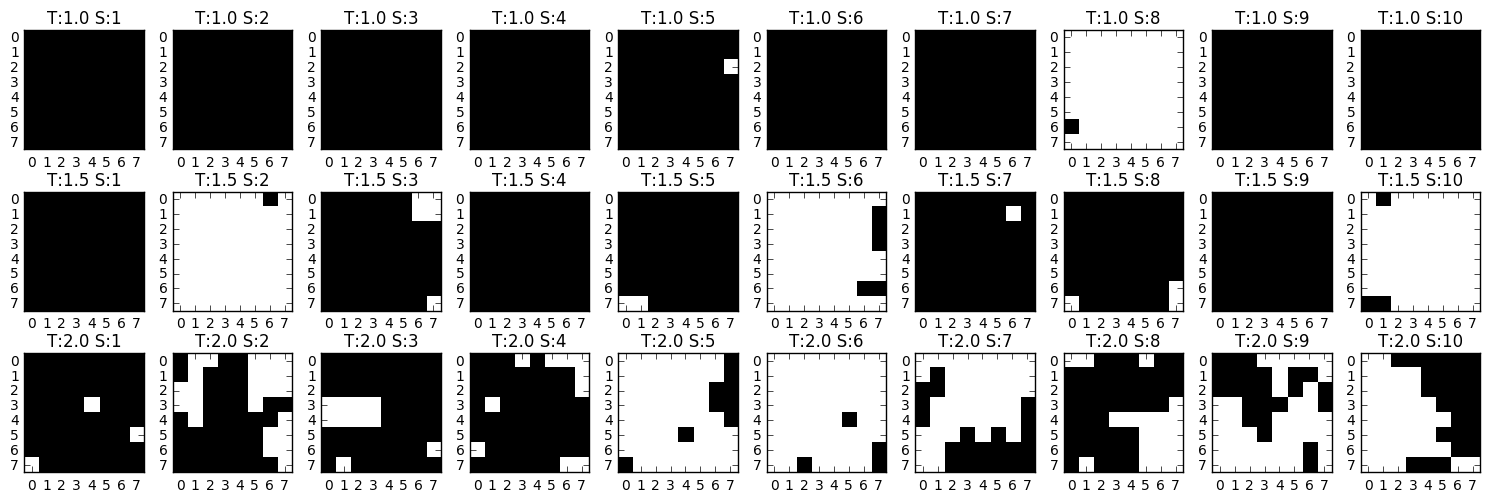

In [10]:
# This block is used for visually debugging and 
#   comparision to the previos exercise.
FIGS=10
plt.figure(30, figsize=(15, 5))
plt.set_cmap('gray')
temp_list = [1., 1.5, 2.]
for i, Temp in enumerate(temp_list):
    for j in range(FIGS):
        sample_image = ising_sampler(ishape=(8, 8), Temp=Temp, ITR=25000)
        plt.subplot(len(temp_list), FIGS, (i * FIGS) + j + 1)
        plt.title("T:{} S:{}".format(Temp, j + 1))
        plt.imshow(sample_image, interpolation='nearest')
plt.tight_layout()

In [11]:
temp_list = [1., 1.5, 2.]
for Temp in temp_list:
    E_11_22 = 0
    E_11_88 = 0
    for j in range(10000):
        sample_image = ising_sampler(ishape=(8, 8), Temp=Temp)
        E_11_22 += sample_image[0, 0] * sample_image[1, 1] 
        E_11_88 += sample_image[0, 0] * sample_image[-1, -1]
    E_11_22 /= 10000
    E_11_88 /= 10000
    print("Temp: {} E_11_22: {} E_11_88: {}".format(
          Temp, E_11_22, E_11_88))

Temp: 1.0 E_11_22: 0.9324 E_11_88: 0.5146
Temp: 1.5 E_11_22: 0.7432 E_11_88: 0.3424
Temp: 2.0 E_11_22: 0.5134 E_11_88: 0.0966


In [13]:
temp_list = [1., 1.5, 2.]
ishape = (8, 8)
BURN_TIME = 100
for Temp in temp_list:
    E_11_22 = 0
    E_11_88 = 0
    X = ising_rand_img(ishape=ishape)
    for j in range(25000):
        X = ising_sweap(X, Temp=Temp)
        if j >= BURN_TIME:
            E_11_22 = (((j - BURN_TIME) * E_11_22 +
                       X[0, 0] * X[1, 1]) / (j - BURN_TIME + 1))
            E_11_88 = (((j - BURN_TIME) * E_11_88 +
                       X[0, 0] * X[-1, -1]) / (j - BURN_TIME + 1))
    print("Temp: {} E_11_22: {} E_11_88: {}".format(
          Temp, E_11_22, E_11_88))

Temp: 1.0 E_11_22: 0.952208835341 E_11_88: 0.906746987952
Temp: 1.5 E_11_22: 0.773172690763 E_11_88: 0.560642570281
Temp: 2.0 E_11_22: 0.50297188755 E_11_88: 0.118473895582


# Execise 1

The results from the nearly exact computation were:

Temp: 1 E_11_22: 0.9552 E_11_88: 0.9128

Temp: 1.5 E_11_22: 0.7594 E_11_88: 0.554

Temp: 2 E_11_22: 0.4918 E_11_88: 0.131

From the results we can infer (as expected), that both of the methods tend toward the nearly exact values.

The first method receives results with higher variance compared to the nearly exact values, while the second method receives nearly the same results as the nearly exact values.

From those results we see the power of ergodicity, the more iterations given the more accurate the model becomes.

# Computer Exercise 2

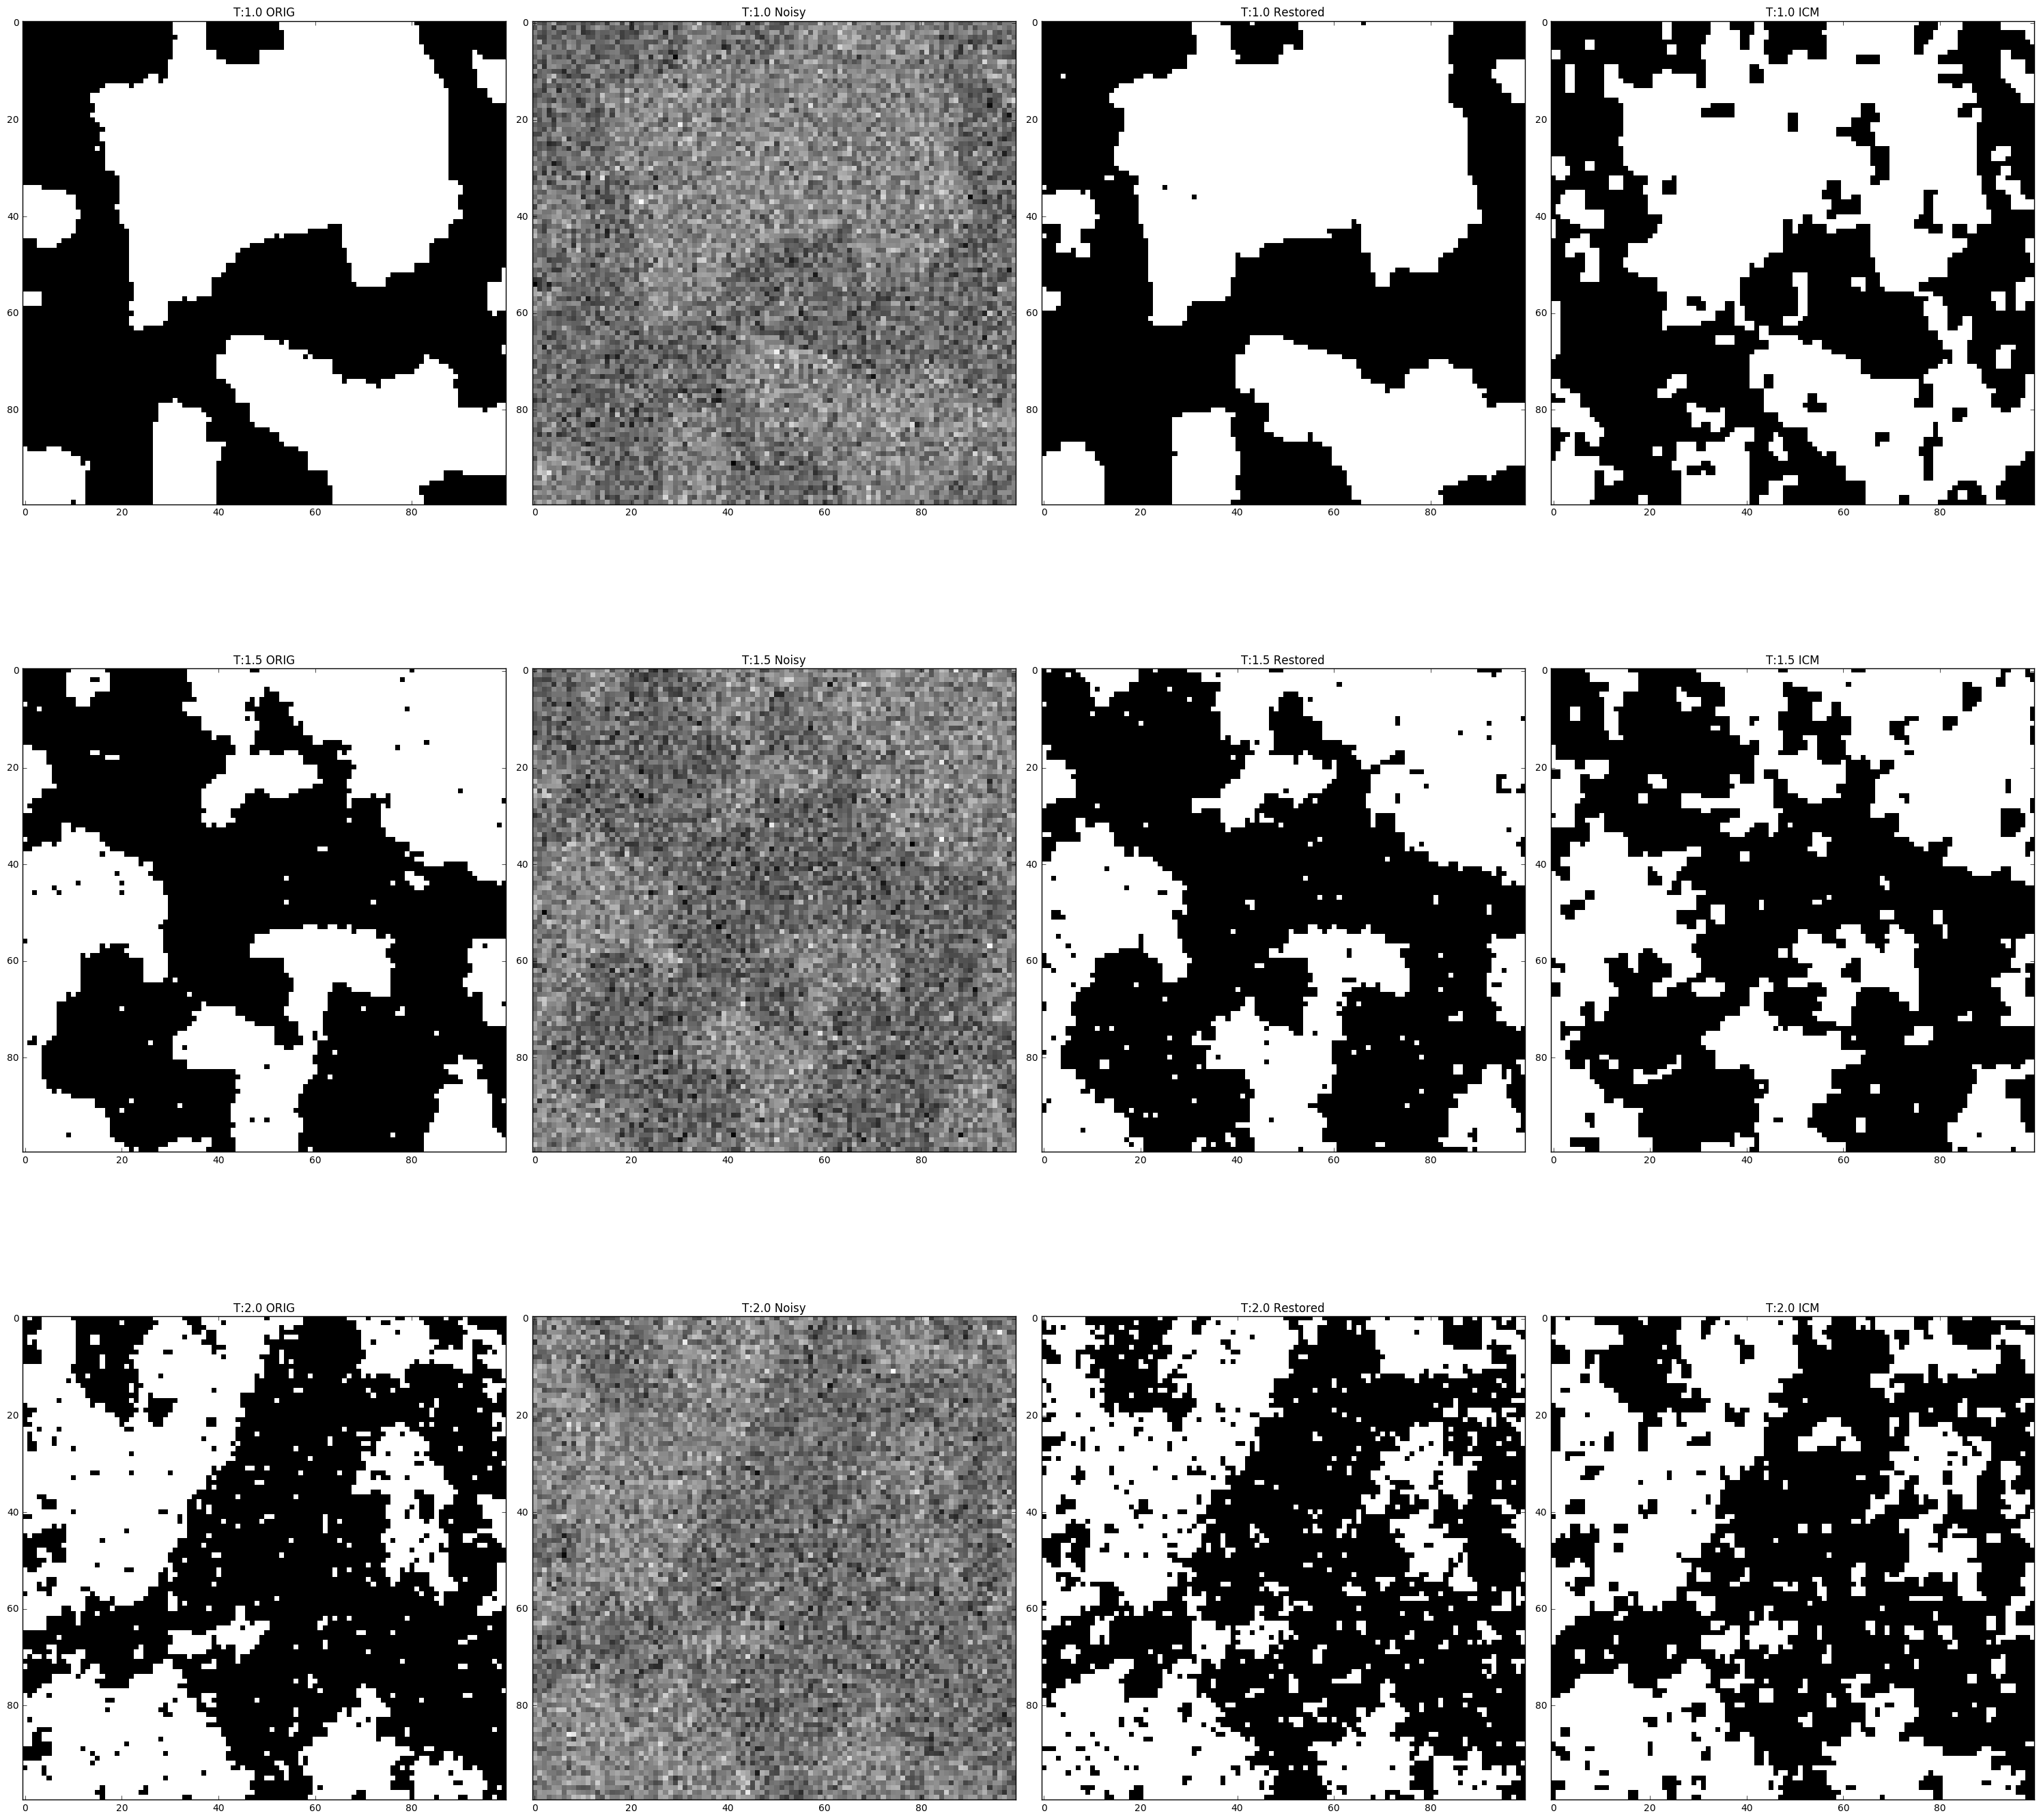

In [7]:
plt.figure(12, figsize=(30, 30))
plt.set_cmap('gray')
temp_list = [1., 1.5, 2.]
ishape = (100, 100)
for i, Temp in enumerate(temp_list):
    X = ising_sampler(ishape=ishape, Temp=Temp, ITR=50)
    plt.subplot(3, 4, (i * 4) + 1)
    plt.title("T:{} ORIG".format(Temp))
    plt.imshow(X, interpolation='nearest')
    Y = X + 2 * np.random.standard_normal(size=ishape)
    plt.subplot(3, 4, (i * 4) + 2)
    plt.title("T:{} Noisy".format(Temp))
    plt.imshow(Y, interpolation='nearest')
    sample_image = ising_sampler_noisy(Y, ishape=ishape, 
                                       Temp=Temp, sigma=2, 
                                       ITR=50, is_icm=False)
    plt.subplot(3, 4, (i * 4) + 3)
    plt.title("T:{} Restored".format(Temp))
    plt.imshow(sample_image, interpolation='nearest')
    sample_image = ising_sampler_noisy(Y, ishape=ishape, 
                                       Temp=Temp, sigma=2, 
                                       ITR=50, is_icm=True)
    plt.subplot(3, 4, (i * 4) + 4)
    plt.title("T:{} ICM".format(Temp))
    plt.imshow(sample_image, interpolation='nearest')
plt.tight_layout()